# Trabalho Prático Aprendizagem Automática


In [30]:
import re, pickle, time, datetime
from tempfile import TemporaryDirectory

from sklearn.svm import LinearSVC,SVC

import numpy as np

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score , GridSearchCV , RandomizedSearchCV

from sklearn.metrics import confusion_matrix, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.pipeline import Pipeline


from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
#Possiveis de serem usadas : numpy, scipy, matplotlib, sklearn, nltk, re e opencv 

Carregar os ficheiros

In [2]:
with open('imdbCriticas.p', 'rb') as f:
    global D, Docs, y
    D = pickle.load(f)
    Docs = D.data
    y = D.target

with open('tfidf_dump.p', 'rb') as f:
    global tfidf
    tfidf = pickle.load(f)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [3]:
tfidf

TfidfVectorizer(max_df=0.5, min_df=4, ngram_range=(1, 2), stop_words='english',
                token_pattern='\\b\\w{3,}\\b')

Podemos analisar a quantidade de reviews de cada uma das possíveis reviews

### Quantidade de reviews por categoria

{1: 8352, 2: 3690, 3: 3923, 4: 4245, 7: 3744, 8: 4529, 9: 3612, 10: 7905}


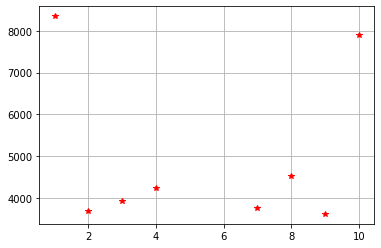

In [7]:
rating, value=np.unique(y,return_counts=True)
print(dict(zip(rating, value)))
plt.plot(rating,value,'*r')
plt.grid()


###  Pré processamento de dados de texto

Usamos este metodo para préprocessar os dados de texto, e reduzir as palavras tendo em conta os erros de ortografia

O stemmer por defeito é o lancaster, porque teve os melhores resultados e se o argumento não corresponder a nenhum outro, este é utilizado

In [65]:
def preProcessDoc(Doc, stemmer = 'lancaster', decode = False):
    stem = {
        'porter'   : PorterStemmer(),
        'snowball' : SnowballStemmer('english'),
        'lancaster': LancasterStemmer()
    }
    stemFunc = stem.get(stemmer, LancasterStemmer())
    if(decode):
        Doc = Doc.decode('UTF-8')
    Doc = Doc.replace('<br />', ' ')
    Doc = re.sub(r'[^a-zA-Z\u00C0\u00FF]+', ' ', Doc)
    Doc = ' '.join([stemFunc.stem(w) for w in Doc.split()])
    return Doc

def preProcessDocs(Docs, stemmer='lancaster', decode = False):
    return [preProcessDoc(doc, stemmer, decode) for doc in Docs]

def text2vector(Docs, tfidf=None,preProcess = False, stemmer='lancaster', decode=False):
    if(preProcess):
        Docs = preProcessDocs(Docs, stemmer=stemmer, decode=decode)
    
    if(tfidf==None):
        tfidf = pickle.load(open('tfidf_dump.p','rb'))

    return tfidf.transform(Docs)

def binClassify(X, clf=None):
    if(clf==None):
        clf = pickle.load(open('svc_bool_dump.p' , 'rb'))
    
    return clf.predict(X)

def multiClassify(X, clf=None):
    if(clf==None):
        clf = pickle.load(open('RidgeMultidump.p', 'rb'))
    return clf.predict(X)

## Classificação Binária

Converter da escala de 0 a 10, para negativos/positivos

In [5]:
y_boolean = [0 if val<5 else 1 for val in y]

### Steemers

O stemmer reduz uma palavra á sua raiz, ou seja, remove plurais, conjugacao de verbos, etc

#### Porter

In [7]:
X = preProcessDocs(Docs, stemmer='porter')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 26773
0.9455


#### Snowball

In [8]:
X = preProcessDocs(Docs, stemmer='snowball')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 26394
0.945375


#### Lancaster

In [9]:
X = preProcessDocs(Docs, stemmer='lancaster')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 21883
0.9394


In [10]:
print('P' ,26773/0.945525)
print('S' ,26394/0.94535)
print('L' ,21883/0.939425)

P 28315.486105602708
S 27919.818056804357
L 23294.036245575753


É possivel ver que o lancaster é o que reduz ao maximo a quantidade de tokens, alem disso vamos optar por utilizar o Lancaster pois precisava de uma quantidade de tokens menores para atingir os teoricos 100% de score.

## Comparar modelos lineares

In [6]:
with open('docs_dump.p', 'rb') as f:
    X = pickle.load(f)

In [11]:
X = preProcessDocs(Docs)
with open('docs_dump.p', 'wb') as f:
    pickle.dump(X, f)

In [6]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    global pipeline, grid_param, grid_search
    
    pipeline =Pipeline([
        ('tfidf' , TfidfVectorizer()),
        ('clf' , LogisticRegressionCV(max_iter = 1000, tol=1e-3))
    ], memory=tmpdir, verbose=True)

    grid_param ={
        'tfidf__strip_accents' :[None, 'unicode'],
        #'tfidf__stop_words' : [None, 'english'],
        'tfidf__token_pattern' : [r'\b\w{3,}\b', r'\b[a-zA-Z]{3,}\b'], #
        'tfidf__min_df' : np.arange(3, 6, 1), #
        'tfidf__max_df' : [0.25, 0.5, 0.75], 
        #'tfidf__min_df' : [3,4,5],
        #'tfidf__min_df' : [3],
        #'tfidf__ngram_range' : [(i,j) for i in range(1,5) for j in range(1,5)],
        'tfidf__ngram_range' : [(1,1), (1,2), (1,3) , (2,2)] , # BBBBB
        'tfidf__norm' : ['l1', 'l2'],
        'tfidf__max_features' : [None, 15000,20000,25000,30000],

        #'clf__C' : np.linspace(0.1,10,100),
        'clf__Cs' : [1,3,10,30,100], 
        #'clf__C' : [3.3],
        'clf__solver' : ['sag', 'saga'],
        #'clf__tol' : (1e-3, 1e-4, 1e-5)
    }
    t0 =time.localtime()
    print('Started at'  , time.strftime("%H:%M:%S", t0))
    ## Se tiveres mais memoria que eu(8Gb), aumenta o pre_dispatch para um valor maior
    grid_search = RandomizedSearchCV(pipeline, grid_param, cv = 5, n_jobs=-1, verbose=3,\
                                     pre_dispatch=8,n_iter = 30).fit(X, y_boolean)

    t1 = time.localtime()
    print('Done at' , time.strftime("%H:%M:%S", t1))
    
with open('dump.p', 'wb') as f:
    pickle.dump({'in' : grid_param ,
                 'out': grid_search}, f)

Started at 15:16:13
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 56.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 28.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Done at 16:17:27


In [7]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
             print('\t' * (indent+1) + str(value))

pretty(grid_search.cv_results_, 0)

mean_fit_time
	[690.02867977  37.32141058 369.89045056 137.35754371 456.18932152
 184.8494792  236.27336701 402.69934948 289.6661249  756.45097788
 268.18874661 187.31101513  66.68613791 175.29305712  90.3015159 ]
std_fit_time
	[ 5.4261045   4.62307497 50.23601666  1.57604928  8.96949775  3.51713334
  4.20336944  3.99793306 11.44582785 18.09002713  7.72037476  1.22601322
  0.6180658   4.00822898 15.02676939]
mean_score_time
	[7.50773851 5.12932785 6.34752345 4.35355218 5.90589515 6.3094004
 4.53880405 6.44200897 3.91615399 5.21079381 9.53086813 6.47203175
 6.27580039 4.19172374 2.21245686]
std_score_time
	[0.21851615 0.71846843 0.46596361 0.10303288 0.20755637 0.20009386
 0.14472093 0.11510817 0.48230765 0.36749729 0.60210629 0.21899587
 0.3289914  0.46973708 0.67657892]
param_tfidf__token_pattern
	['\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b'
 '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b'
 '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b\\w{3,}\\b' '\\

In [23]:
print(grid_search.best_index_)
print(grid_search.best_estimator_)

0
Pipeline(memory='C:\\Users\\pedro\\AppData\\Local\\Temp\\sklearn_graph_cache_mwl12peq',
         steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=4, ngram_range=(1, 2),
                                 token_pattern='\\b[a-zA-Z]{3,}\\b')),
                ('norm', Normalizer(norm='l1')),
                ('clf',
                 LogisticRegressionCV(Cs=3, max_iter=1000, solver='saga',
                                      tol=0.001))])


## Em vez de correr o codigo em cima, podemos fazer import do ficheiro dump

In [8]:
with open('dump.p' ,'rb') as f:
    global grid_param, grid_search
    temp = pickle.load(f)
    grid_param = temp['in']
    grid_search = temp['out']
print(grid_search.best_estimator_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Normalizer from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid res

Pipeline(memory='C:\\Users\\pedro\\AppData\\Local\\Temp\\sklearn_graph_cache_mwl12peq',
         steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, min_df=4, ngram_range=(1, 2),
                                 token_pattern='\\b[a-zA-Z]{3,}\\b')),
                ('norm', Normalizer(norm='l1')),
                ('clf',
                 LogisticRegressionCV(Cs=3, max_iter=1000, solver='saga',
                                      tol=0.001))])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [22]:
#print(grid_search.cv_results_.keys())

for i in range(len(grid_search.cv_results_['std_test_score'])):
    print(f'TOKEN PATTERN : {grid_search.cv_results_["param_tfidf__token_pattern"][i]} , '+
          f'\nMinDF {grid_search.cv_results_["param_tfidf__min_df"][i]}' +
          f'\nResult {grid_search.cv_results_["mean_test_score"][i]} \n\n')

TOKEN PATTERN : \b[a-zA-Z]{3,}\b , 
MinDF 4
Result 0.8994001136214096 


TOKEN PATTERN : \b[a-zA-Z]{3,}\b , 
MinDF 3
Result 0.5052500000065624 


TOKEN PATTERN : \b[a-zA-Z]{3,}\b , 
MinDF 3
Result 0.8954751692401128 


TOKEN PATTERN : \b[a-zA-Z]{3,}\b , 
MinDF 4
Result 0.8756750698428478 


TOKEN PATTERN : \b[a-zA-Z]{3,}\b , 
MinDF 4
Result 0.893025171736988 


TOKEN PATTERN : \b[a-zA-Z]{3,}\b , 
MinDF 4
Result 0.8879501348565663 


TOKEN PATTERN : \b[a-zA-Z]{3,}\b , 
MinDF 3
Result 0.8687250423348479 


TOKEN PATTERN : \b[a-zA-Z]{3,}\b , 
MinDF 3
Result 0.8971501229933628 


TOKEN PATTERN : \b\w{3,}\b , 
MinDF 4
Result 0.8809001498473791 


TOKEN PATTERN : \b\w{3,}\b , 
MinDF 4
Result 0.8849000642295194 


TOKEN PATTERN : \b\w{3,}\b , 
MinDF 3
Result 0.8937751567383004 


TOKEN PATTERN : \b\w{3,}\b , 
MinDF 4
Result 0.8877501373562539 


TOKEN PATTERN : \b\w{3,}\b , 
MinDF 4
Result 0.5052500000065624 


TOKEN PATTERN : \b\w{3,}\b , 
MinDF 3
Result 0.8657000323313166 


TOKEN PATTERN :

###  TFIDF optimizado

Não é exatamente o mesmo que foi eleito pelo pipeline, mas este remove stop words e palavras redundantes porque ajuda a reduzir o ruido

In [99]:
with open('tfidf_dump.p', 'wb') as f:
    tfidf = TfidfVectorizer(max_df=0.5 , min_df=4,ngram_range=(1, 2), norm='l2', token_pattern=r'\b\w{3,}\b'\
                            ,stop_words='english').fit(X)
    pickle.dump(tfidf, f)

In [100]:
len(tfidf.get_feature_names())

174366

### Classificacao booleana

In [166]:
vector = text2vector(X)
vector.shape

(40000, 174366)

In [17]:
with open('vector_dump.p', 'wb') as f:
    pickle.dump(vector, f)

In [25]:
with open('vector_dump.p', 'rb') as f:
    vector = pickle.load(f)

In [28]:
##tfidf = TfidfVectorizer(min_df = 3, token_pattern=r'\b\w{3,}\b', norm = 'l2' , ngram_range=(1,2)).fit(Docs)
dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga', n_jobs=-1).fit(vector,y_boolean)
print(dl.score(vector, y_boolean))
print(dl.scores_)

1.0
{1: array([[0.50525 , 0.888   , 0.896375],
       [0.50525 , 0.89375 , 0.90275 ],
       [0.50525 , 0.89875 , 0.90475 ],
       [0.50525 , 0.90375 , 0.913625],
       [0.50525 , 0.89575 , 0.909375]])}


In [29]:
x_train, x_test, y_train, y_test = train_test_split(vector, y_boolean, test_size=1/4)

dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga', n_jobs=-1).fit(x_train, y_train)
print(dl.score(x_train, y_train))
print(dl.score(x_test, y_test))

1.0
0.9069


### Classificacao multi-classe

In [23]:
x_train, x_test, y_train, y_test = train_test_split(vector, y, test_size=1/4)

dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga').fit(x_train, y_train)
print(dl.score(x_train, y_train))
print(dl.score(x_test, y_test))

0.8051
0.4466


# Linear SVC (multiclasse)

In [22]:
X1,X2,y1,y2=train_test_split(vector,y,test_size=1/4)

In [23]:
svm=LinearSVC(dual=False,C=1).fit(X1,y1)

In [24]:
ye=svm.predict(X2)

In [25]:
print("tamanho y: ",y.shape)
print("tamanho ye: ",ye.shape)
print('N erros(teste):',np.sum(y2!=ye))

tamanho y:  (40000,)
tamanho ye:  (8000,)
N erros(teste): 4813


In [26]:
print("Linear SVC Score train: ", svm.score(X1,y1))

Linear SVC Score train:  0.85334375


In [27]:
print("Linear SVC Score test: ", svm.score(X2,y2))

Linear SVC Score test:  0.398375


Estas condições de teste não são as mais adequadas para o conjunto de dados pois como podemos visualizar no teste acima, os valores de score para o conjunto de train e teste são bastante díspares,sendo o de train bastante bom ao contrário do de test que não é muito bom.

# Linear SVC (booleana)

In [57]:
X1,X2,y1,y2=train_test_split(vector,y_boolean,test_size=1/4)

In [58]:
svm=LinearSVC(dual=False,C=1).fit(X1,y1)

In [59]:
ye=svm.predict(X2)

In [44]:
print("tamanho ye: ",ye.shape)
print('N erros(teste):',np.sum(y2!=ye))

tamanho ye:  (10000,)
N erros(teste): 952


In [45]:
print("Linear SVC Score test: ", svm.score(X1,y1))

Linear SVC Score test:  0.9993


In [46]:
print("Linear SVC Score test: ", svm.score(X2,y2))

Linear SVC Score test:  0.9048


In [60]:
with open('svc_bool_dump.p', 'wb') as f:
    pickle.dump(svm, f)

### MultinomialNB ( ‘Naive Bayes' ) (Multiclasse)

In [32]:
X1,X2,y1,y2=train_test_split(vector,y,test_size=1/4)
clf = MultinomialNB().fit(X1, y1)
y2e = clf.predict(X2)


In [35]:
print('N erros(teste):',np.sum(y2!=y2e))
print('Score ', clf.score(X2, y2))

N erros(teste): 6318
Score  0.3682


In [36]:
X1,X2,y1,y2=train_test_split(vector,y_boolean,test_size=1/4)
clf = MultinomialNB().fit(X1, y1)
y2e = clf.predict(X2)

print('N erros(teste):',np.sum(y2!=y2e))
print('Score ', clf.score(X2, y2))

N erros(teste): 1136
Score  0.8864


## Decomposição em componentes principais

Temos 40000 documentos, com 170000 tokens, logo para reduzir a complixidade usamos LDA. A LDA remove os componentes com pouco relevo.

In [ ]:
vector.shape

In [167]:
pca = TruncatedSVD(n_components=100).fit(vector)

In [168]:
sum(pca.explained_variance_ratio_)

0.0530847474352232

In [8]:
with open('pca_dump.p' ,'wb') as f:
    pickle.dump(pca , f)

In [80]:
list = [10,20,30,50,100,200,300,500]

for n_comps in list:
    pca = TruncatedSVD(n_components=n_comps, n_iter=2).fit(vector)
    print(f'Num Componentes {n_comps : >10} ||  Variance {pca.explained_variance_ratio_.sum() : .10f}')

Num Componentes         10 ||  Variance  0.0145753481
Num Componentes         20 ||  Variance  0.0210284684
Num Componentes         30 ||  Variance  0.0261841245
Num Componentes         50 ||  Variance  0.0347922198
Num Componentes        100 ||  Variance  0.0521353079
Num Componentes        200 ||  Variance  0.0791129334
Num Componentes        300 ||  Variance  0.1008270827
Num Componentes        500 ||  Variance  0.1364963751


In [8]:
with open('pca_dump.p' , 'rb') as f:
    global pca
    pca = pickle.load(f)

In [157]:
pca

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
             random_state=None, tol=0.0)

In [158]:
vec = pca.transform(vector)
vec.shape

(40000, 100)

In [108]:
dl = LogisticRegressionCV(Cs=3, max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2', solver='saga', 
                     tol=0.001).fit(vec, y_boolean)
print(dl.score(vec, y_boolean))
for target, score in dl.scores_.items():
    print(f'Class {target} \nScore {score}\n\n')

0.86865
Class 1 
Score [[0.50525  0.859125 0.864875]
 [0.50525  0.864625 0.864875]
 [0.50525  0.863375 0.86525 ]
 [0.50525  0.870375 0.871125]
 [0.50525  0.863    0.865125]]




In [112]:
dl = LogisticRegressionCV(Cs=3, max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2', solver='saga', 
                     tol=0.001).fit(vec, y)
print(dl.score(vec, y))
for target, score in dl.scores_.items():
    print(f'Class {target} \nScores\n{score}\n\n')

0.43515
Class 1 
Scores
[[0.208875 0.417125 0.419875]
 [0.208875 0.4245   0.4295  ]
 [0.20875  0.42525  0.427125]
 [0.20875  0.421125 0.43175 ]
 [0.20875  0.422    0.42975 ]]


Class 2 
Scores
[[0.208875 0.417125 0.419875]
 [0.208875 0.4245   0.4295  ]
 [0.20875  0.42525  0.427125]
 [0.20875  0.421125 0.43175 ]
 [0.20875  0.422    0.42975 ]]


Class 3 
Scores
[[0.208875 0.417125 0.419875]
 [0.208875 0.4245   0.4295  ]
 [0.20875  0.42525  0.427125]
 [0.20875  0.421125 0.43175 ]
 [0.20875  0.422    0.42975 ]]


Class 4 
Scores
[[0.208875 0.417125 0.419875]
 [0.208875 0.4245   0.4295  ]
 [0.20875  0.42525  0.427125]
 [0.20875  0.421125 0.43175 ]
 [0.20875  0.422    0.42975 ]]


Class 7 
Scores
[[0.208875 0.417125 0.419875]
 [0.208875 0.4245   0.4295  ]
 [0.20875  0.42525  0.427125]
 [0.20875  0.421125 0.43175 ]
 [0.20875  0.422    0.42975 ]]


Class 8 
Scores
[[0.208875 0.417125 0.419875]
 [0.208875 0.4245   0.4295  ]
 [0.20875  0.42525  0.427125]
 [0.20875  0.421125 0.43175 ]
 [0.20875  

### Clustering

Depois de termos os componentes principais podemos partir para o clustering

## Clustering, demora um bocado. Tipo 20 minutos para 100 componentes
Ajuda a calcular o numero de cluster otimo, entre 8 e max_k

In [169]:
min_k = len(np.unique(y))
max_k = 100
indx = np.linspace(min_k,max_k, num=20, dtype=np.uint8)
sse = []

for k in indx:
    kmeans = KMeans(n_clusters = k)

    sse.append(kmeans.fit(x_train).inertia_)
    print (str(k) + ": "+ str(silhouette_score(x_train, kmeans.labels_, metric='euclidean')))

8: 0.01727609164102796
12: 0.014671603641129204
17: 0.014547233811309844
22: 0.01070997376350327
27: 0.006392872912502531
32: 0.00032030175785603763
37: 0.0010240857668412985
41: 0.0018852309922306925
46: -0.002698102085462428
51: -0.0028233905116202373
56: -0.00427956890341355
61: -0.0043870379380380855
66: -0.006350922973037516
70: -0.004228058886275824
75: -0.007984401596689141
80: -0.0063800567906028265
85: -0.00808473661769697
90: -0.00866850582134188
95: -0.006716387106266033
100: -0.009438970326674


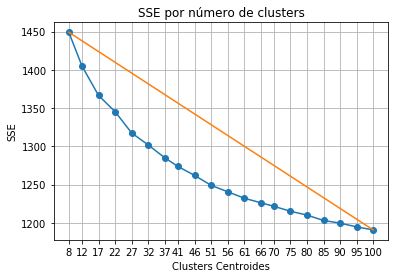

In [170]:
plt.plot(indx, sse, marker='o')
plt.plot([min_k, max_k] , [sse[0], sse[len(sse)-1]])


plt.xlabel('Clusters Centroides')
plt.xticks(indx)
plt.ylabel('SSE')
plt.title('SSE por número de clusters')
plt.grid(True)


In [171]:
x1, y1 = min_k, sse[0]
x2, y2 = max_k, sse[len(sse)-1]

distances = []
for i in range(len(wcss)):
    x0 = indx[i]
    y0 = wcss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(np.round(numerator/denominator , 6))

best_n = indx[distances.index(max(distances))]
print(best_n)

37


In [176]:
with open('dump_cluster.p ', 'wb') as f:
    pickle.dump({
        'indx' : indx,
        'sse' : sse,
        'distances' : distances,
        'best_n' : best_n
    }, f)

In [172]:
km = KMeans(n_clusters=best_n).fit(x_train)

In [173]:
print("Top terms per cluster:")
original_space_centroids = pca.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
for i in range(len(km.cluster_centers_)):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end=',')
    print()

Top terms per cluster:
Cluster 0: thi movy, tim, watch, just, hor, mor, lik, gre, som, saw,
Cluster 1: lov, ther, story, gre, watch, charact, good, som, just, scen,
Cluster 2: good, wil, wer, ther, mus, plot, thi film, gre, charact, dant,
Cluster 3: watch, bad, just, don, end, gre, tim, watch thi, thi movy, anim,
Cluster 4: funny, good, comedy, just, gre, scen, best, mus, gam, wil,
Cluster 5: thi movy, gre, lov, story, gam, real, play, wil, lik, best,
Cluster 6: ther, kil, lik, don, think, lif, charact, end, plot, just,
Cluster 7: just, charact, wel, thi film, mor, ther, play, kid, seen, thing,
Cluster 8: real, guy, charact, book, ther, lov, thi movy, did, end, lik,
Cluster 9: thi movy, bad, tim, watch, ther, lov, year, funny, lik, seen,
Cluster 10: lik, bad, gre, thi film, peopl, ther, just, som, lov, mak,
Cluster 11: lik, episod, watch, just, sery, peopl, tim, don, wer, think,
Cluster 12: lik, just, real, ther, tim, watch, episod, mor, don, wer,
Cluster 13: thi film, tim, watch, lov,

In [174]:
original_space_centroids.shape

(37, 174366)

# Bibliografia

### Geral
- Slides Professor

### Pré processamento do texto
- https://blog.ekbana.com/pre-processing-text-in-python-ad13ea544dae
- https://medium.com/@wenxuan0923/feature-extraction-from-text-using-countvectorizer-tfidfvectorizer-9f74f38f86cc

### Escolher o classificador
- https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

### Grid Search
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
- https://www.youtube.com/watch?v=Gol_qOgRqfA

### Pipeline
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

### Clustering
- https://medium.com/hanman/data-clustering-what-type-of-movies-are-in-the-imdb-top-250-7ef59372a93b
- https://jtemporal.com/kmeans-and-elbow-method/

### Naive Bayse
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

### Decomposição PCA/LSA
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD
- https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
- https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8